# Quantum pipeline using t|ket> backend

In [1]:
import numpy as np

def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            labels.append([1, 0] if line[0] == '1' else [0, 1])
            sentences.append(line[1:].strip())
    return np.array(labels), sentences


train_labels, train_data = read_data('datasets/mc_train_data.txt')
dev_labels, dev_data = read_data('datasets/mc_dev_data.txt')
test_labels, test_data = read_data('datasets/mc_test_data.txt')

### Create diagrams

In [2]:
from lambeq.ccg2discocat import DepCCGParser

reader = DepCCGParser(possible_root_cats=['S[dcl]'])

train_diagrams = reader.sentences2diagrams(train_data)
dev_diagrams = reader.sentences2diagrams(dev_data)
test_diagrams = reader.sentences2diagrams(test_data)

### Create circuits

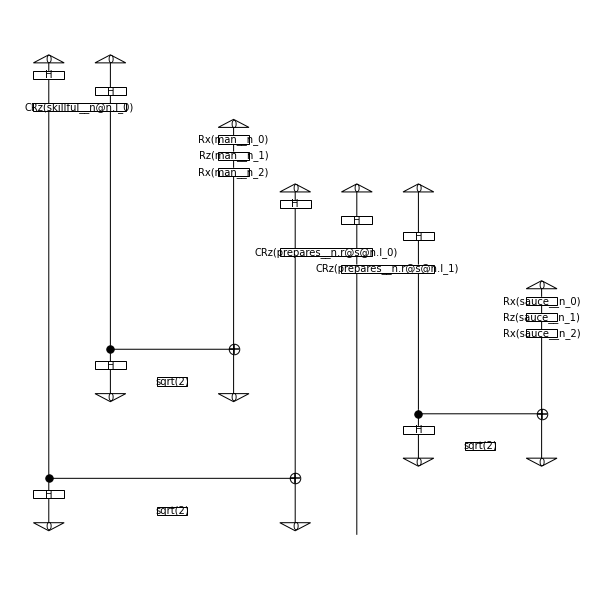

In [3]:
from lambeq.circuit import IQPAnsatz
from lambeq.core.types import AtomicType

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(8, 8))

### Parameterise

In [4]:
from sympy import default_sort_key

all_circuits = train_circuits + dev_circuits + test_circuits

# sort the symbols since they are returned as a set
parameters = sorted(
    {s for circ in all_circuits for s in circ.free_symbols},
    key=default_sort_key)

In [5]:
from discopy.quantum import Id, Measure
from discopy.tensor import Tensor
from pytket.extensions.qiskit import AerBackend

backend_config = {
    'backend': AerBackend(),
    'compilation': AerBackend().default_compilation_pass(2)
}

def normalise(predictions):
    # apply smoothing to predictions
    predictions = np.abs(predictions + 1e-9)
    return predictions / predictions.sum()


def make_pred_fn(circuits):
    def predict(params):
        measured_circuits = [c >> Id().tensor(*[Measure()] * len(c.cod)) for c in circuits]
        return np.array(
            [normalise(np.abs(c.lambdify(*parameters)(*params).eval(**backend_config).array))
             for c in measured_circuits])
    return predict


train_pred_fn = make_pred_fn(train_circuits)
dev_pred_fn = make_pred_fn(dev_circuits)
test_pred_fn = make_pred_fn(test_circuits)

### Train

In [6]:
from noisyopt import minimizeSPSA
import numpy

def make_cost_fn(pred_fn, labels):
    def cost_fn(params, **kwargs):
        predictions = pred_fn(params)

        cost = -np.sum(labels * np.log2(predictions)) / len(labels)  # binary cross-entropy loss
        costs.append(cost)

        acc = np.sum(np.round(predictions) == labels) / len(labels) / 2  # half due to double-counting
        accuracies.append(acc)

        return cost
    
    costs, accuracies = [], []
    return cost_fn, costs, accuracies


numpy.random.seed(0)
rng = numpy.random.default_rng(0)
x0 = np.array(rng.random(len(parameters)))

train_cost_fn, train_costs, train_accs = make_cost_fn(train_pred_fn, train_labels)
dev_cost_fn, dev_costs, dev_accs = make_cost_fn(dev_pred_fn, dev_labels)

result = minimizeSPSA(train_cost_fn, x0=x0, a=0.13, c=0.1, niter=400, callback=dev_cost_fn)

### Show results

Test accuracy: 0.9833333333333333


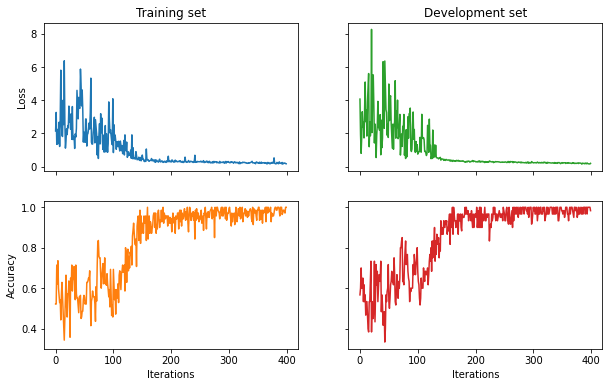

In [7]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row')
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(train_costs[1::2], color=next(colours))  # training evaluates twice per iteration
ax_bl.plot(train_accs[1::2], color=next(colours))   # so take every other entry
ax_tr.plot(dev_costs, color=next(colours))
ax_br.plot(dev_accs, color=next(colours))

# print test accuracy
test_cost_fn, _, test_accs = make_cost_fn(test_pred_fn, test_labels)
test_cost_fn(result.x)
print('Test accuracy:', test_accs[0])